In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchaudio

from torch.nn import Conv1d, ConvTranspose1d, AvgPool1d, Conv2d
from torch.nn.utils import weight_norm, remove_weight_norm, spectral_norm

import librosa
import torchyin

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Audio, display
from scipy.interpolate import CubicSpline

### Pitch Estimation and Speech Template Generation

In [2]:
def generate_speech_template(audio_file):
    # Load audio file
    audio, sr = librosa.load(audio_file, mono=True)

    # Compute pitch using torchyin library
    pitch = torchyin.estimate(audio, sample_rate=sr)

    # Compute mel spectrogram using torchaudio library
    mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=2048, hop_length=256)
    mel_spec = mel_spec_transform(torch.Tensor(audio)).numpy()
    
    speech_template = np.zeros_like(audio)
    voiced_indices = np.where(pitch > 0)[0]
    
    for i in range(len(voiced_indices)):
        idx = voiced_indices[i]
        f0 = pitch[idx]
        pulse_length = int(np.round(sr/f0))
        pulse = np.zeros(pulse_length)
        pulse[0] = 1
        speech_template[idx:idx+pulse_length] += pulse


    unvoiced_indices = np.where(pitch <= 0)[0]
    for i in range(len(unvoiced_indices)):
        idx = unvoiced_indices[i]
        speech_template[idx] = np.random.uniform(-1, 1)

    return speech_template, pitch, torch.tensor(mel_spec.reshape(1,128,-1))

In [3]:
template, pitch, mel_spec = generate_speech_template('./reference.wav')

## Model Architecture

In [4]:
class ResBlock(torch.nn.Module):
    def __init__(self, channels, kernel_size=1, dilation=(1, 3)):
        super(ResBlock, self).__init__()
        
        self.convs = nn.ModuleList([ 
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[0])),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[1]))
        ])

    def forward(self, x):
        for c in self.convs:
            xt = F.leaky_relu(x, 0.1)
            xt = c(xt)
            x = xt + x
        return x

In [5]:
class UNet(nn.Module):
    def __init__(self, input_channels=1, mel_channels=128, output_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            ResBlock(16),
        )
        self.enc2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            ResBlock(32),
        )
        self.enc3 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            ResBlock(64),
        )
        self.enc4 = nn.Sequential(
            nn.Conv1d(64, mel_channels, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
        )

        self.padding = nn.ConstantPad1d((0, 1), 0)
        
        # Decoder
        self.dec1 = nn.Sequential(
            nn.ConvTranspose1d(mel_channels * 2, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.LeakyReLU(),
            ResBlock(64),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose1d(64 * 2, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.LeakyReLU(),
            ResBlock(32),
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose1d(32 * 2, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.LeakyReLU(),
            ResBlock(16),
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose1d(16 * 2, output_channels, kernel_size=5, stride=2, padding=2),
        )

    def forward(self, waveform, mel_spectrogram):
        # Encoder
        enc1_out = self.enc1(waveform)
        enc2_out = self.enc2(enc1_out)
        enc3_out = self.enc3(enc2_out)
        enc4_out = self.enc4(enc3_out)

        mel_spectrogram_resized = torch.nn.functional.interpolate(mel_spectrogram, size=enc4_out.shape[-1], mode='nearest')

        enc4_out_cat = torch.cat((enc4_out, mel_spectrogram_resized), dim=1)

        dec1_out = self.dec1(enc4_out_cat)
        dec1_out_cat = torch.cat((dec1_out, enc3_out), dim=1)

        dec2_out = self.dec2(dec1_out_cat)
        dec2_out_cat = torch.cat((dec2_out, self.padding(enc2_out)), dim=1)

        dec3_out = self.dec3(dec2_out_cat)
        dec3_out_cat = torch.cat((dec3_out, self.padding(self.padding(self.padding(enc1_out)))), dim=1)

        output = self.dec4(dec3_out_cat)
        return output

## Running the Code

In [10]:
# Example usage
audio_file = "./reference.wav"
mel_channels = 128
waveform, sample_rate = torchaudio.load(audio_file)
waveform = waveform.unsqueeze(0) 

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=2048, hop_length=256)(waveform)
mel_spectrogram = mel_spectrogram.reshape(1,mel_channels,-1)

# Instantiate the model
model = UNet()
mel_spec.reshape(1,128,-1)
# Forward pass
output = model(waveform, mel_spectrogram)
output

tensor([[[-0.1945,  0.0383,  0.1302,  ...,  0.7100,  0.0566,  0.8229]]],
       grad_fn=<ConvolutionBackward0>)

## Defining Losses

In [7]:
def spectrogram_loss(ref_mel, gen_mel):
    return torch.nn.functional.mse_loss(ref_mel, gen_mel, reduction='mean')

def envelope_loss(ref, gen):
    m = nn.MaxPool1d(5, stride=3)
    mae = nn.L1Loss()
    
    return mae(m(ref), m(gen)) + mae(m(-ref), m(-gen))

## Visualizing Waves

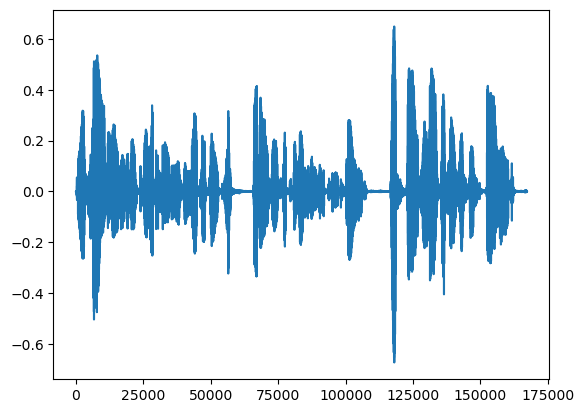

In [8]:
plt.plot(waveform.detach().reshape(-1))
plt.show()

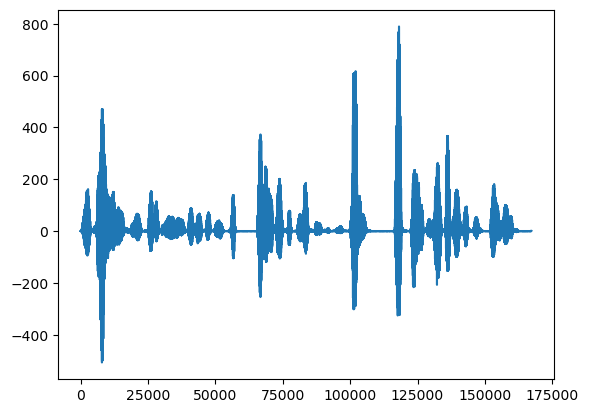

In [11]:
plt.plot(output.detach().reshape(-1))
plt.show()